# Machine learning

`scikit-learn`, `xgboost`를 활용하여 간단한 machine learning 모델 학습 및 테스트

In [50]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, r2_score)

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, pickle, time

## Classification

### iris dataset

scikit-learn에 있는 간단한 classification 모델들 활용

In [60]:
iris_data = pd.read_csv('../data/iris.csv')
# 타겟과 특성 분리
x = iris_data.drop(['Id', 'Species'], axis=1)
y = iris_data['Species']

# 훈련 세트와 테스트 세트 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# 데이터 표준화 / 각 feature의 scale을 맞춤
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
# test 데이터에 대해서는 scaler를 학습시키지 않음
x_test_scaled = scaler.transform(x_test)

# 모델 정의
iris_models = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

iris_results = {}
for name, model in iris_models.items():
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    iris_results[name] = {
        'prec': precision_score(y_test, y_pred, average='macro'), 
        'rec':recall_score(y_test, y_pred, average='macro'),
        'f1':f1_score(y_test, y_pred, average='macro'),
        'acc':accuracy_score(y_test, y_pred),
        'pred':y_pred,
    }

In [55]:
print('{:20s} | {:>9s} | {:>8s} | {:>8s} | {:>8s}'.format('Model name','Precision','Recall','F1-score','Accuracy'))
print('-'*65)
for name, data in iris_results.items():
    print('{:20s} | {:9.4f} | {:8.4f} | {:8.4f} | {:8.4f}'.format(name, data['prec'], data['rec'], data['f1'], data['acc']))

Model name           | Precision |   Recall | F1-score | Accuracy
-----------------------------------------------------------------
Logistic Regression  |    0.9524 |   0.9697 |   0.9585 |   0.9667
SVC                  |    0.9141 |   0.9141 |   0.9141 |   0.9333
Decision Tree        |    0.9524 |   0.9697 |   0.9585 |   0.9667
Random Forest        |    0.9524 |   0.9697 |   0.9585 |   0.9667
KNN                  |    0.8714 |   0.8838 |   0.8755 |   0.9000


- Classification 성능 지표
  - precision : 모델이 Positive로 예측한 label의 개수 대비 실제 정답 label이 Positive인 개수 비율
  - recall : 실제 정답 label이 Positive인 개수 대비 모델이 Positive로 예측한 label의 개수 비율
  - F1 score : Precision과 Recall의 조화 평균
  - Accuracy : label을 맞힌 비율
  

- Confusion matrix

In [84]:
cm = confusion_matrix(y_test, iris_results['Logistic Regression']['pred'])
print('|           | prd.0 | prd.1 | prd.2 | Recall')
print('-'*45)
print('|   truth 0 | {:5d} | {:5d} | {:5d} | {:.3f}'.format(*cm[0], cm[0,0] / cm[0].sum()))
print('|   truth 1 | {:5d} | {:5d} | {:5d} | {:.3f}'.format(*cm[1], cm[1,1] / cm[1].sum()))
print('|   truth 2 | {:5d} | {:5d} | {:5d} | {:.3f}'.format(*cm[2], cm[2,2] / cm[2].sum()))
print('-'*45)
print('| Precision | {:.3f} | {:.3f} | {:.3f} |'.format(
    cm[0,0] / cm[:,0].sum(), cm[1,1] / cm[:,1].sum(), cm[2,2] / cm[:,2].sum()
))


|           | prd.0 | prd.1 | prd.2 | Recall
---------------------------------------------
|   truth 0 |    13 |     0 |     0 | 1.000
|   truth 1 |     0 |     6 |     0 | 1.000
|   truth 2 |     0 |     1 |    10 | 0.909
---------------------------------------------
| Precision | 1.000 | 0.857 | 1.000 |


In [85]:
print('Accuracy  : {:.5f}'.format(29/30))
print('Precision : {:.5f}'.format(np.mean([cm[0,0] / cm[:,0].sum(), cm[1,1] / cm[:,1].sum(), cm[2,2] / cm[:,2].sum()])))
print('Recall    : {:.5f}'.format(np.mean([cm[0,0] / cm[0].sum(), cm[1,1] / cm[1].sum(), cm[2,2] / cm[2].sum()])))

Accuracy  : 0.96667
Precision : 0.95238
Recall    : 0.96970


### mnist dataset

In [179]:
with gzip.open('../data/mnist.pkl.gzip','rb') as f:
    mnist = pickle.load(f)

x_train = mnist['train']['x']
y_train = mnist['train']['y']
x_test = mnist['test']['x']
y_test = mnist['test']['y']

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

mnist_models = {
    "Logistic Regression": LogisticRegression(), # 최적화 경고
    "SGD Classifier": SGDClassifier(), # 오래걸림
    "SVC": SVC(), # 오래걸림
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    'XGB': XGBClassifier()
}

mnist_results = {}
for name, model in mnist_models.items():
    t1 = time.time()
    model.fit(x_train_scaled[:20000], y_train[:20000]) # 오래걸려서 일부 데이터만 활용
    y_pred = model.predict(x_test_scaled)
    mnist_results[name] = {
        'prec': precision_score(y_test, y_pred, average='macro'), 
        'rec':recall_score(y_test, y_pred, average='macro'),
        'f1':f1_score(y_test, y_pred, average='macro'),
        'acc':accuracy_score(y_test, y_pred),
        'pred':y_pred}
    print(name, f'{time.time() - t1:.4f} sec', mnist_results[name])

/home/jhyang/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 1.9340 sec {'prec': 0.8983882109292962, 'rec': 0.8980726471792057, 'f1': 0.8981293148924445, 'acc': 0.8995, 'pred': array([7, 2, 1, ..., 4, 5, 6], dtype=int16)}


/home/jhyang/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD Classifier 76.8264 sec {'prec': 0.9046007596942415, 'rec': 0.9003933070534134, 'f1': 0.9011408200869022, 'acc': 0.9016, 'pred': array([7, 2, 1, ..., 4, 5, 6], dtype=int16)}
SVC 78.5029 sec {'prec': 0.9521102258454757, 'rec': 0.9512382577119816, 'f1': 0.9515416726378373, 'acc': 0.9519, 'pred': array([7, 2, 1, ..., 4, 5, 6], dtype=int16)}
Decision Tree 2.8835 sec {'prec': 0.8393827812414963, 'rec': 0.8391794076598703, 'f1': 0.8392148261601532, 'acc': 0.8414, 'pred': array([7, 2, 3, ..., 4, 8, 6], dtype=int16)}
Random Forest 7.5438 sec {'prec': 0.9592535750318578, 'rec': 0.9590484717012766, 'f1': 0.9591006844128804, 'acc': 0.9594, 'pred': array([7, 2, 1, ..., 4, 5, 6], dtype=int16)}
KNN 1.1513 sec {'prec': 0.9280221748046513, 'rec': 0.9267047438305263, 'f1': 0.9267953005548282, 'acc': 0.9276, 'pred': array([7, 2, 1, ..., 4, 5, 6], dtype=int16)}
XGB 32.7330 sec {'prec': 0.9661647698319238, 'rec': 0.9659772012767623, 'f1': 0.9660355147373387, 'acc': 0.9663, 'pred': array([7, 2, 1, ..., 

In [181]:
print('{:20s} | {:>9s} | {:>8s} | {:>8s} | {:>8s}'.format('Model name','Precision','Recall','F1-score','Accuracy'))
print('-'*65)
for name, data in mnist_results.items():
    print('{:20s} | {:9.4f} | {:8.4f} | {:8.4f} | {:8.4f}'.format(name, data['prec'], data['rec'], data['f1'], data['acc']))

Model name           | Precision |   Recall | F1-score | Accuracy
-----------------------------------------------------------------
Logistic Regression  |    0.8984 |   0.8981 |   0.8981 |   0.8995
SGD Classifier       |    0.9046 |   0.9004 |   0.9011 |   0.9016
SVC                  |    0.9521 |   0.9512 |   0.9515 |   0.9519
Decision Tree        |    0.8394 |   0.8392 |   0.8392 |   0.8414
Random Forest        |    0.9593 |   0.9590 |   0.9591 |   0.9594
KNN                  |    0.9280 |   0.9267 |   0.9268 |   0.9276
XGB                  |    0.9662 |   0.9660 |   0.9660 |   0.9663


In [185]:
y_test = mnist['test']['y']
y_pred = mnist_results['XGB']['pred']
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 968,    0,    0,    0,    0,    2,    4,    1,    4,    1],
       [   0, 1120,    3,    4,    0,    1,    3,    1,    3,    0],
       [   6,    1,  992,    8,    6,    0,    4,    8,    7,    0],
       [   1,    0,    7,  979,    0,    5,    1,    8,    7,    2],
       [   1,    0,    1,    1,  946,    0,    5,    1,    6,   21],
       [   4,    1,    1,   13,    0,  850,   10,    4,    8,    1],
       [   4,    3,    0,    0,    6,    7,  931,    0,    7,    0],
       [   1,    4,   25,    4,    2,    0,    0,  980,    2,   10],
       [   6,    1,    6,    6,    6,    4,    4,    1,  933,    7],
       [   6,    5,    1,    7,   11,    3,    0,    5,    7,  964]])

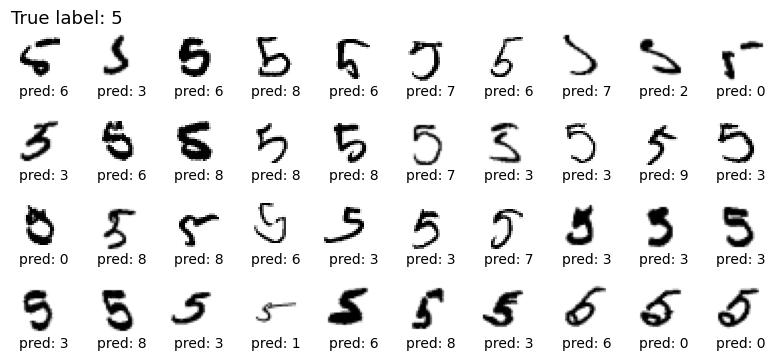

In [186]:
j = 5

mask = (y_test == j) & (y_pred != j)
f, axs = plt.subplots(4, 10, figsize=(10, 4))
axs = axs.reshape(-1)
axs[0].text(0,-3, f'True label: {j}', fontsize=13)
for ax in axs: ax.axis('off')
for i, (ax, idx) in enumerate(zip(axs, np.where(mask)[0])):
    axs[i].imshow(mnist['test']['x'][idx].reshape(28,28), cmap='gray_r')
    axs[i].text(4,33, f'pred: {y_pred[idx]}')
f.subplots_adjust(hspace=0.5, wspace=0)

- 데이터 규모에 따른 성능 비교 

In [189]:
num_data = [100, 1000, 5000, 10000, 20000, 30000, 60000]
np.random.seed(100)
output = {}
for n in num_data:
    output[n] = []
    # 5 회 반복 훈련
    for _ in range(5):
        # n 개의 index 임의로 추출
        idxs = np.random.randint(0, 60000, n)
        # 빠르고 성능이 적당한 KNN 모델 활용. 
        model = KNeighborsClassifier()
        model.fit(x_train_scaled[idxs], y_train[idxs])
        y_pred = model.predict(x_test_scaled)
        output[n].append([
            precision_score(y_test, y_pred, average='macro'),
            recall_score(y_test, y_pred, average='macro'),
            f1_score(y_test, y_pred, average='macro'),
            accuracy_score(y_test, y_pred),
        ])

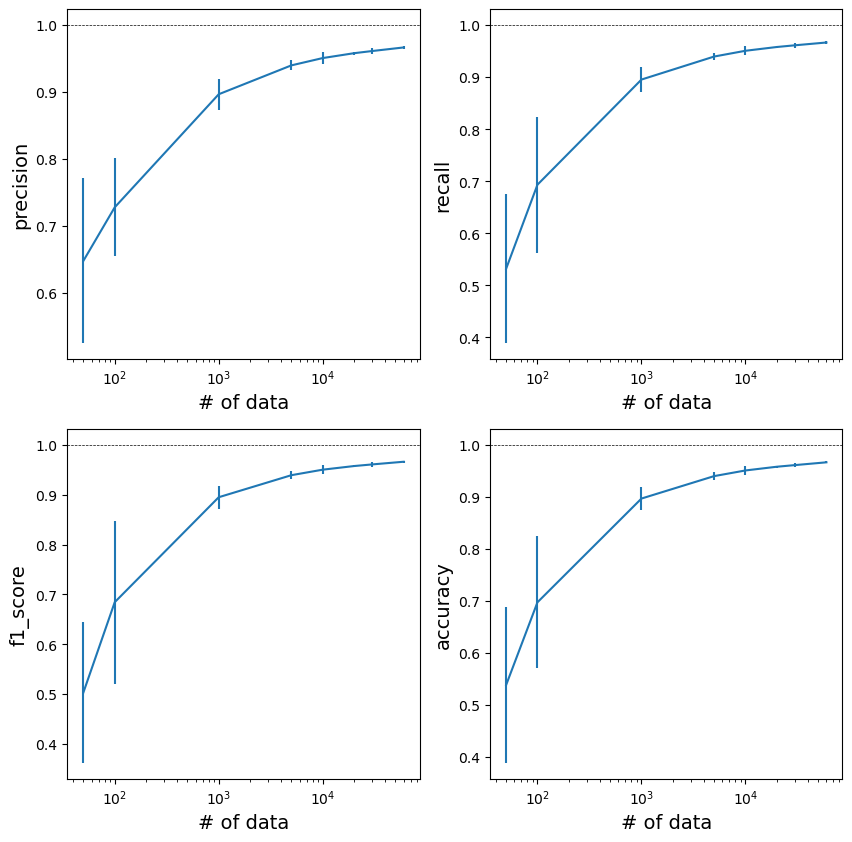

In [174]:
data_size = list(output.keys())
mat = np.array(list(output.values())).transpose(2,0,1)
val = mat.mean(-1)
err = mat.std(-1)
f, axs = plt.subplots(2,2,figsize=(10, 10))
for i, (ax, metric) in enumerate(zip(axs.reshape(-1), ['precision','recall','f1_score','accuracy'])):
    ax.errorbar(data_size, val[i], yerr=err[i] * 5) # error를 보기 위해 5배 확대함
    ax.set_xscale('log')
    ax.axhline(1, ls='--', color=[0,0,0], lw=0.5)
    ax.set_ylabel(metric, fontsize=14)
    ax.set_xlabel('# of data', fontsize=14)
    

## Regression

### Linear model
  - 훈련되는 데이터의 양에 따라 모델의 성능이 달라짐을 확인할 수 있음
  - 단순한 모델이기 때문에 random shuffling 만으로 문제 해결이 가능하지만, 극단적 예시를 위해 순차적으로 데이터를 자름

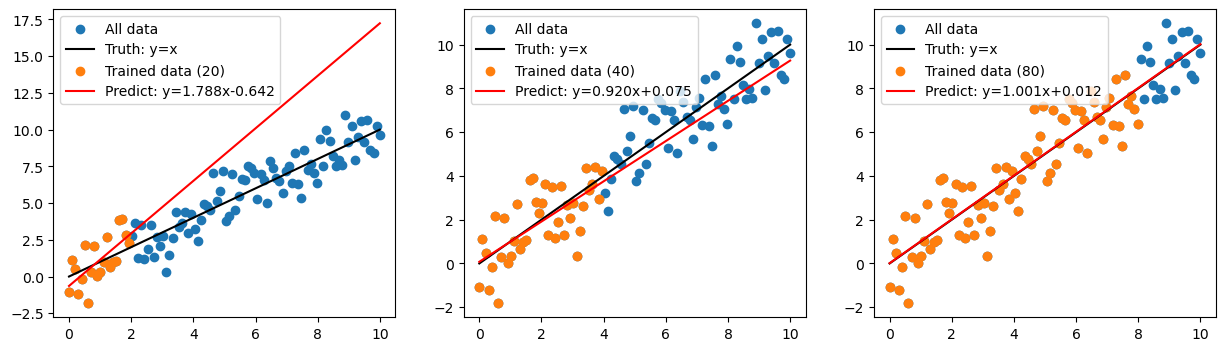

In [2]:

num_data = [20, 40, 80]

np.random.seed(123)
x = np.linspace(0, 10, 100)
y = x + np.random.normal(0, 1, 100)

f, axs = plt.subplots(1, 3,figsize=(15,4))
for n, ax in zip(num_data, axs):
    ax.scatter(x,y, label='All data')
    ax.plot([0,10],[0,10], color='k', label='Truth: y=x')
    model = LinearRegression()
    model.fit(x[:n].reshape(-1,1), y[:n].reshape(-1,1))

    px = [[0], [10]]
    py = model.predict(px)
    ax.scatter(x[:n], y[:n], label=f'Trained data ({n})')
    a, b = model.coef_, model.intercept_
    ax.plot(px,py, color='r', label=f'Predict: y={a[0,0]:.3f}x{b[0]:+.3f}')

    ax.legend(loc='upper left')


### Housing dataset

In [6]:
housing = pd.read_csv('../data/housing.csv')

NaN이 있는지 체크 후 값을 바꿔줘야 함.

In [7]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

NaN 값은 다음과 같이 다룰 수 있음
- NaN이 포함된 데이터를 제거
- NaN이 포함된 특성을 제거
- NaN을 다른 값으로 채움

In [8]:
housing_option_1 = housing.dropna(subset=['total_bedrooms']) # 옵션 1
housing_option_2 = housing.drop('total_bedrooms', axis=1) # 옵션 2
housing_option_3 = housing.copy()
housing_option_3['total_bedrooms'].fillna(0) # 옵션 3 - 0 으로 채우기
median = housing['total_bedrooms'].median() # 중앙값 추출
housing_option_3['total_bedrooms'].fillna(median) # 옵션 3 - 중앙값으로 채우기

print('데이터 형태')
print('orig.  : ', housing.shape)
print('opt. 1 : ', housing_option_1.shape)
print('opt. 2 : ', housing_option_2.shape)
print('opt. 3 : ', housing_option_3.shape)

데이터 형태
orig.  :  (20640, 10)
opt. 1 :  (20433, 10)
opt. 2 :  (20640, 9)
opt. 3 :  (20640, 10)


In [9]:
# 집값을 target으로 분리
housing_target = housing_option_3['median_house_value'].values
# 집값과 텍스트 데이터 제거
housing_num = housing_option_3.drop(['ocean_proximity','median_house_value'], axis=1)
# 새로운 특성 데이터 생성
housing_num["rooms_per_household"] = housing_option_3["total_rooms"]/housing_option_3["households"]
housing_num["bedrooms_per_room"] = housing_option_3["total_bedrooms"]/housing_option_3["total_rooms"]
housing_num["population_per_household"] = housing_option_3["population"]/housing_option_3["households"]

housing_cat = housing_option_3['ocean_proximity']
housing_cat

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

In [10]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
# 정수로 인코딩된 결과
housing_cat_encoded[:10], housing_categories

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Index(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype='object'))

실제 특성간의 유사도를 생각해본다면, NEAR OCEAN과 NEAR BAY, <1H OCEAN 은 유사도가 크지만, euclidean distance를 계산해보면 0과 4의 값을 갖는 NEAR BAY와 NEAR OCEAN은 꽤 먼 거리를 보이므로, 숫자가 데이터의 특성을 잘 나타내지 못함.

One-hot encoding은 이를 해결할 수 있는 간단한 방법 중 하나임

In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)).toarray()
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [12]:
# 하나의 데이터로 결합
housing_feature = np.hstack([housing_num.values, housing_cat_1hot])
housing_feature.shape, housing_num.shape, housing_cat_1hot.shape

((20640, 16), (20640, 11), (20640, 5))

In [21]:
x_train, x_test, y_train, y_test = train_test_split(housing_feature, housing_target, test_size=0.2, random_state=123)

xgb = XGBRegressor()
# scikit-learn의 cross_validate를 이용한 cross validation. 
# 단, estimator가 scikit-learn에 맞게 구현되어 있어야 함.
scores = cross_validate(xgb, x_train, y_train, cv=5)
scores

{'fit_time': array([0.35881996, 0.36325216, 0.34523249, 0.45976591, 0.43283916]),
 'score_time': array([0.0012908 , 0.00163937, 0.00113201, 0.00128365, 0.00121331]),
 'test_score': array([0.85061848, 0.82842498, 0.84247764, 0.81840293, 0.8158282 ])}

[    0     1     2 ... 16509 16510 16511]
[    0     1     2 ... 16509 16510 16511]


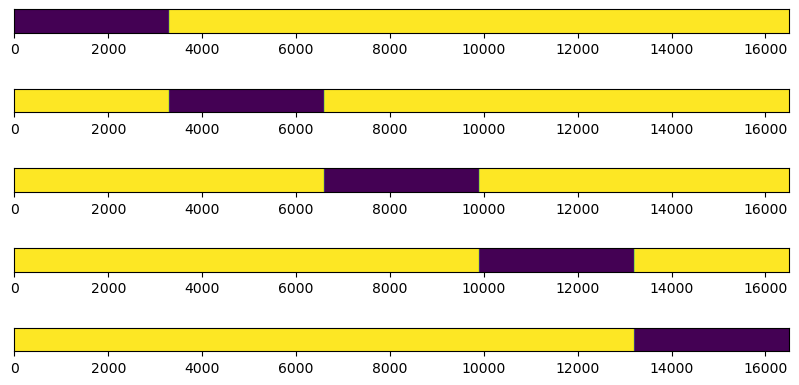

In [43]:
x = x_train
y = y_train
seed = 100
cv = 5

n_total = x.shape[0]
np.random.seed(seed)

# data index 생성 및 shuffle
idxs = np.arange(n_total)
print(idxs)
#np.random.shuffle(idxs)
print(idxs)

chunk_size = int(n_total / cv) + 1

# True 로 되어있는 array 생성
cv_mask = np.ones_like(idxs, dtype=bool)
masks = []
for i in range(cv):
    mask = cv_mask.copy()
    # 일부 구간만 False로 변경
    mask[idxs[i*chunk_size:(i+1)*chunk_size]] = False
    masks.append(mask)

# CV index 시각화
f, axs = plt.subplots(5,1,figsize=(10, 5))
for i in range(5):
    axs[i].imshow(masks[i].astype(int).reshape(1,-1), extent=[0, n_total, 0, 500])
    axs[i].set_yticks([])

In [44]:
# Class로 만들어 관리
class CrossValidation:
    def __init__(self, x, y, cv=5, seed=100):
        self._x = x
        self._y = y
        
        n_total = x.shape[0]
        np.random.seed(seed)

        # data index 생성 및 shuffle
        idxs = np.arange(n_total)
        np.random.shuffle(idxs)

        chunk_size = int(n_total / cv) + 1

        # True 로 되어있는 array 생성
        cv_mask = np.ones_like(idxs, dtype=bool)
        self._mask = []
        for i in range(cv):
            mask = cv_mask.copy()
            # 일부 구간만 False로 변경
            mask[idxs[i*chunk_size:(i+1)*chunk_size]] = False
            self._mask.append(mask)
    
    def __getitem__(self, i):
        mask = self._mask[i] # i 번째 mask
        return self._x[mask], self._y[mask], self._x[~mask], self._y[~mask]

In [49]:
scale_feat = StandardScaler()
scale_target = StandardScaler()

x_train_scaled = scale_feat.fit_transform(x_train)
y_train_scaled = scale_target.fit_transform(y_train.reshape(-1,1))
x_test_scaled = scale_feat.transform(x_test)
y_test_scaled = scale_target.transform(y_test.reshape(-1,1))

cv_scaled = CrossValidation(x_train_scaled, y_train_scaled, cv=5)
cv_original = CrossValidation(x_train, y_train, cv=5)

In [51]:
xgb_cv_results = {'scaled':[], 'original':[]}

for i in range(5):    
    x_tr_sc, y_tr_sc, x_val_sc, y_val_sc = cv_scaled[i]
    xgb_sc = XGBRegressor()
    xgb_sc.fit(x_tr_sc, y_tr_sc)
    p_val_sc = xgb_sc.predict(x_val_sc)
    val_r2_sc = r2_score(y_val_sc, p_val_sc)
    
    x_tr_or, y_tr_or, x_val_or, y_val_or = cv_original[i]
    xgb_or = XGBRegressor()
    xgb_or.fit(x_tr_or, y_tr_or)
    p_val_or = xgb_or.predict(x_val_or)
    val_r2_or = r2_score(y_val_or, p_val_or)
    
    xgb_cv_results['scaled'].append(val_r2_sc)
    xgb_cv_results['original'].append(val_r2_or)

Text(0.5, 0, 'CV Fold number')

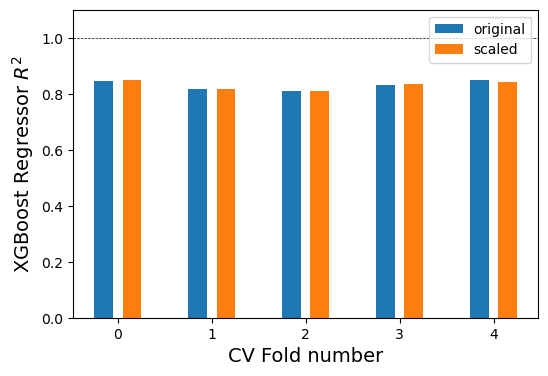

In [128]:
f, ax = plt.subplots(1,1,figsize=(6, 4))
ax.bar(np.arange(5)-0.15, xgb_cv_results['original'], width=0.2, label='original')
ax.bar(np.arange(5)+0.15, xgb_cv_results['scaled'], width=0.2, label='scaled')
ax.axhline(1, ls='--', color='k', lw=0.5)
ax.legend(loc='upper right')
ax.set_ylim([0,1.1])
ax.set_ylabel('XGBoost Regressor $R^2$', fontsize=14)
ax.set_xlabel('CV Fold number', fontsize=14)

data scale 여부에 관계없이 일정한 성능을 보임 - tree 기반 모델의 특징

- Hyperparameter 선택

In [73]:
import os
os.makedirs('.dump', exist_ok=True)

# grid search를 통한 최적의 hyperparameter 탐색
max_depths = [1, 2, 4, 8, 16]
n_estimators = [10, 20, 40, 80, 160]
hp_opt = {}
for max_depth in max_depths:
    for n_esti in n_estimators:
        key = (max_depth, n_esti)
        hp_opt[key] = []
        for i in range(5):
            x_tr, y_tr, x_val, y_val = cv_original[i]
            xgb = XGBRegressor(max_depth=max_depth, n_estimators=n_esti)
            xgb.fit(x_tr, y_tr)
            p_val = xgb.predict(x_val)
            # validation 결과 저장
            hp_opt[key].append(r2_score(y_val, p_val))
            # 다시 불러오기 위해 모델 저장
            xgb.save_model(f'.dump/{max_depth}_{n_esti}.txt')

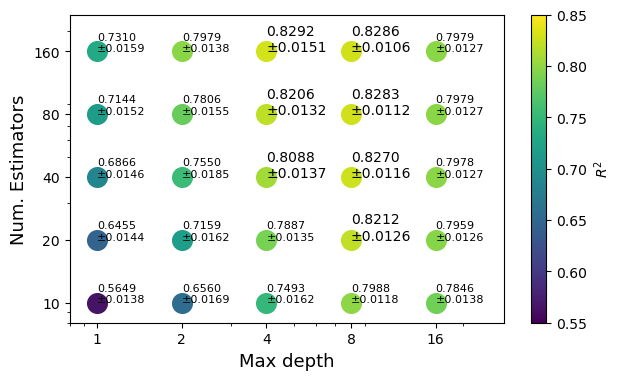

In [130]:
f, ax = plt.subplots(1,1,figsize=(7, 4))
for (max_depth, n_esti), r2s in hp_opt.items():
    r2 = np.mean(r2s)
    im = ax.scatter(max_depth, n_esti, c=r2, vmin=0.55, vmax=0.85, s=200)
    if r2 < 0.8:
        ax.text(max_depth, n_esti, f'{r2:.4f}\n±{np.std(r2s):.4f}', fontsize=8)
    else:
        ax.text(max_depth, n_esti, f'{r2:.4f}\n±{np.std(r2s):.4f}', fontsize=10)
ax.set_xlim([0.8, 28])
ax.set_xlabel('Max depth', fontsize=13)
ax.set_xscale('log')
ax.set_xticks(max_depths, labels=[str(m) for m in max_depths])
ax.set_ylim([8, 240])
ax.set_ylabel('Num. Estimators', fontsize=13)
ax.set_yscale('log')
ax.set_yticks(n_estimators, labels=[str(m) for m in n_estimators])
plt.colorbar(im, ax=ax, label='$R^2$')

In [131]:
# 모델 불러오기
xgb.load_model('.dump/4_160.txt')
p_test = xgb.predict(x_test)
print(f'Test R2: {r2_score(y_test, p_test):.4f}')

Test R2: 0.8396
